In [17]:
import numpy as np
import scipy
import pickle
import time
import tqdm
import h5py
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [109]:
class Deprecated(Exception):
    """Deprecated function
    """

    def __init__(self):
        super().__init__("FUNCTION HAS BEEN DEPRECATED")

In [110]:
def update_params(x):
    """Calculates cosmological parameters given some input
    
    Args:
      x: A dictionary containing input parameters. Required keys include
               'fa' : The axion decay constant in planck units
            'gstar' : The (constant) number of relativistic degrees of freedom
         and optionally 
           'eta_PQ' : The conformal time, fixed to eta = 1 at H = fa
          'eta_QCD' : The conformal time, fixed to eta = 1 at H = ma(T) (temperature dependent axion mass)
           'Lambda' : Lambda_QCD in planck units. 
    
    Returns:
      Dictionary containing cosmological parameters. Subscripts of _PQ or _QCD refer to 
      either the PQ-era simulations or early-QCD era simulations. 
      
    """
    
    #Given fa scale, find all the fixed PQ scale stuff
    x['T1_PQ']   = np.sqrt(45*x['fa']/(4*np.pi**3))*(x['gstar']**(-1/4))
    x['Tc_PQ']   = np.sqrt(3)*x['fa']
    x['c']       = x['T1_PQ']**2/(3*x['fa']**2) #convenience parameter for PQ evolution
    x['etac_PQ'] = (5/(4*(np.pi**3)*81))**(1/4)/(x['fa']**(1/2))
    
    #Given fa scale and Lambda_QCD, find all the QCD scale stuff. I'm taking LambdaQCD = 400 MeV
    if 'Lambda' in x: 
        print(r"WARNING: Asserting all QCD scales scale linearly with $\Lambda_\mathrm{QCD}$")
        # mu = 2.3 md = 4.8 
        # mpi/LQCD = 135/400
        # fpi/LQCD = 130/400
        x['ma']     =  (x['Lambda']**2)*((135/400)*(130/400)/x['fa'])*np.sqrt((2.3*4.8)/((2.3+4.8)**2))
        x['T1_QCD'] =  x['Lambda']*((45/(4*np.pi**3*x['gstar']))*(x['fa']**(-2))*x['alpha'])**(1/(4+x['n']))
        x['t1_QCD'] =  np.sqrt(45/(16*np.pi**3))*(x['gstar']**(-1/2))*(x['T1_QCD']**(-2))
        x['H1_QCD'] =  np.sqrt(4*np.pi**3/45)*(x['gstar']**(1/2))*x['T1_QCD']**2
        x['Tc_QCD'] =  x['Lambda']*((x['alpha']*x['Lambda']**4)/(x['fa']**2*x['ma']**2))**(1/x['n'])
        x['tc_QCD'] =  np.sqrt(45/(16*np.pi**3))*(x['gstar']**(-1/2))*(x['Tc_QCD']**(-2))
        x['etac_QCD'] = (x['tc_QCD']/x['t1_QCD'])**(1/2)
        x['eta1_QCD_PQ'] = (45/(4*np.pi**3*x['gstar']))**(1/4)*x['fa']**(1/2)*x['T1_QCD']**(-1) #eta1_QCD in PQ units
        x['lambda_tilde'] = (x['fa']/x['H1_QCD'])**2
        print("CHECK: Normal hierarchy T1_PQ > Tc_PQ > T1_QCD > Tc_QCD:")
        print("CHECK",x['T1_PQ'],x['Tc_PQ'],x['T1_QCD'],x['Tc_QCD'])
        print(f"CHECK: PQ-oscillations start at eta_PQ = 1, and PQ breaking happens at eta_PQ = {x['etac_PQ']}")
        print(f"CHECK: Then we need to simulate until around eta_PQ = {x['eta1_QCD_PQ']} (eta_QCD = 1) which is")
        print(f"CHECK: where the QCD mass osciollations start. Then, the field oscillates until")
        print(f"CHECK: eta_QCD = {x['etac_QCD']} at which point the mass has attained")
    
    #Given a reference eta, or temperature, find all the other things at the reference time
    if 'eta_PQ' in x.keys():
        x['T'] = (45/(4*np.pi**3*81))**(1/4)*np.sqrt(x['fa'])/x['eta_PQ']
    elif 'eta_QCD' in x.keys():
        x['t'] = (x['eta_QCD']**2)*(x['t1_QCD'])
        x['T'] = (4*np.pi/(16*np.pi**3*x['gstar']))**(1/4)*(x['t']**(-1/2))
    elif 'T' in x.keys():
        x['eta_PQ'] = (45/(4*np.pi**3*81))**(1/4)*np.sqrt(x['fa'])/x['T']
        if 'Lambda' in x:
            #x['eta_QCD'] = 
            raise NotImplemented
    
    x['H'] = np.sqrt(4*np.pi**3/45)*(x['gstar']**(1/2))*x['T']**2
    if 't' not in x.keys():
        x['t'] = np.sqrt(45/(16*np.pi**3))*(x['gstar']**(-1/2))
    else:
        print("CHECK: spotcheck (should be zero)",np.sqrt(45/(16*np.pi**3))*(x['gstar']**(-1/2)) - x['t'])
    return x

In [111]:
def RK4(f,t,y,h):
    """One RK4 step, assumes f(t,y) := y', with a stepsize h
    """
    k1 = f(t,y)
    k2 = f(t+h/2,y+h*k1/2)
    k3 = f(t+h/2,y+h*k2/2)
    k4 = f(t+h,y+h*k3)
    return y + (1/6)*(k1+2*k2+2*k3+k4)*h

def RKN4(f,t,y,yp,h):
    """One RKN step, assumes f(t,y) := y'', with a stepsize h
    """
    k1 = f(t,y)
    k2 = f(t+ (h/2),y + (h/2)*yp + (h**2)*(1/8)*k1)
    k3 = f(t+h, y+h*yp+(h**2)*(1/2)*k2)
    return np.array([y + h*yp + (h**2)*((k1/6)+(k2/3)),
            yp + h*((k1/6)+(4*k2/6)+(k3/6))])

def grad(field,dir,order,N):
    """Gradient of a field in some direction at some order. 
    
    Take derivative of a field, in a specific direction,
    with some number of points included (stencil number).
    TODO: think of it as a convolved stencil, use fft methods
    (fix the fourier transform)

    Inputs:
        field: real numpy array
        dir: axis to compute
        order: order of derivative to compute
        N: number of points to include
    """
    
    if (order,N) == (2,3):
        return (np.roll(field,-1,axis=dir) + \
               -2*field + \
               np.roll(field,1,axis=dir))
    if (order,N) == (2,7):
        return (2*np.roll(field,-3,axis=dir) + \
               -27*np.roll(field,-2,axis=dir) + \
               270*np.roll(field,-1,axis=dir) + \
               -490*field + \
               270*np.roll(field,1,axis=dir) + \
               -27*np.roll(field,2,axis=dir) + \
               2*np.roll(field,3,axis=dir))/180
    else:
        print(order,N)
        raise NotImplementedError

def rescaled_nabla(field,a,N=3):
    """Rescaled laplacian of a field 
    
    Inputs:
        field: complex field, possibly 2D, or 3D, with shape
               Lx x Ly x (Lz)
            a: scale factor 
            
    Returns:
      Rescaled laplacian (by scale factor a)
    """
    return np.sum([grad(field,i,2,N) for i in range(len(field.shape))],axis=0)/(a**2)

def PQ_epoch_diff_rescaled(field,params,lamb=0.1,debug=False):
    """Returns the second derivative of the field in PQ era
    
    Returns the second derivative of the field, when we have rewritten the 
    equation to not have single derivative terms. See the writeup for details.
    
    Inputs:
       field: complex field, possibly 2D or 3D, with shape
              Lx x Ly x (Lz)
      params: dictionary containing cosmological parameters. 
        lamb: lambda, set to one by default. 
    
    Returns:
      Second derivative of field (with respect to eta)
    """
    return rescaled_nabla(field,params['set_scale']) \
           -params['set_lambda']*field*(np.abs(field)**2 - params['eta_PQ']**2 + params['set_c'])
    #return rescaled_nabla(field,params['a']/params['fa']) \
    #        -lamb*field*(np.abs(field)**2 - params['eta_PQ']**2 + params['c'])

def earlyQCD_epoch_diff_rescaled(field,params,debug=False):
    """Returns the second derivative of the field in earlyQCD era.
    
    Returns the second derivative of the field, when we have rewritten the 
    equation to not have single derivative terms. See the writeup for details.
    
    Inputs:
       field: complex field, possibly 2D or 3D, with shape
              Lx x Ly x (Lz)
      params: dictionary containing cosmological parameters. 
    
    Returns:
      Second derivative of field (with respect to eta)
    """
    #return rescaled_nabla(field,params['a']/params['fa']) \
    #       -params['set_lambda_tilde']*field*(np.abs(field)**2 - params['eta_QCD']**2) \
    #       -params['eta_QCD']**4*min(params['eta_QCD'],params['set_etac_QCD'])**params['n']*np.abs(field)**(-3)*\
    #        (-np.imag(field)**2+1j*np.real(field)*np.imag(field))
    return rescaled_nabla(field,params['set_scale']) \
           -params['set_lambda_tilde']*field*(np.abs(field)**2 - params['eta_QCD']**2) \
           -params['eta_QCD']**4*min(params['eta_QCD'],params['set_etac_QCD'])**params['n']*np.abs(field)**(-3)*\
            (-np.imag(field)**2+1j*np.real(field)*np.imag(field))

def earlyQCD_epoch_diff_rescaled_N(field,params,debug=False):
    """Returns the second derivative of the field in earlyQCD era, with arbitrary N
    
    Returns the second derivative of the field, when we have rewritten the 
    equation to not have single derivative terms. See the writeup for details.
    
    Inputs:
       field: complex field, possibly 2D or 3D, with shape
              Lx x Ly x (Lz)
      params: dictionary containing cosmological parameters. 
    
    Returns:
      Second derivative of field (with respect to eta)
    """
    #print("N")
    return rescaled_nabla(field,params['set_scale']) \
           -params['set_lambda_tilde']*field*(np.abs(field)**2 - params['eta_QCD']**2) \
           -params['eta_QCD']**4*min(params['eta_QCD'],params['set_etac_QCD'])**params['n']*np.abs(field)**(-2)*\
            1j*field*np.sin(params['N']*np.angle(field))/params['N']

def PQ_epoch_diff(field,fieldp,params,lamb=1,debug=False):
    """DEPRECATED: please see PQ_epoch_diff_rescaled
    
    y'' = f(t,y,y'), this is that function f. (in the PQ epoch)
    a:  dimensionless "Lattice spacing" (old: L_phys (in units of H1) / L_lat (number of sites))
    c : T1**2/3fa**2
    """
    raise Deprecated
    A = -(2/params['eta_PQ'])*fieldp 
    B = rescaled_nabla(field,params['a']/params['fa'])
    C = -lamb*field*((params['eta_PQ']**2)*\
                         (np.repeat(np.expand_dims(np.sum(field**2,axis=0),0),2,0) - 1) + params['c'])
    
    return A + B + C
    
def earlyQCD_epoch_diff(field,fieldp,params,lamb=1,debug=False):
    """DEPRECATED: please see earlyQCD_epoch_diff_rescaled
    
    Note that lamb = 1 is the lamb from PQ evolution. 
    """
    raise Deprecated
    A = -(2/params['eta_QCD'])*fieldp 
    B = rescaled_nabla(field,params['a']*params['eta_PQ']/params['H1_QCD']) #Is this eta_PQ or eta_QCD? Its.... I need to fix this
                                                    #its with respect to a1 H1 x, where 1 is now 1_QCD
    C = -(lamb*params['fa']**2/(params['H1_QCD']**2))\
            *field*(params['eta_QCD']**2)*(np.repeat(np.expand_dims(np.sum(field**2,axis=0),0),2,0) - 1)
    D0 = (min(params['eta_QCD'],params['etac_QCD'])**params['n'])*\
                    (params['eta_QCD']**2)*(np.sum(field**2,axis=0)**(-3/2))
    D1 = -field[1]**2; D2 = field[0]*field[1]
    D = np.stack((D1/D0,D2/D0),axis=0)
    return A + B + C + D
    

In [112]:
def thermal(shape,
            params,
            lamb=1):
    """Initial thermal distribution
    
    Generates an initial thermal distribution, to be used 
    before the PQ transition. 
    
    Inputs:
       shape: shape of the field
      params: cosmological params
      
    Returns
      complex field, along with its derivative in eta. 
      Returns the field *not* scaled by eta (so just in the dimensionless form, 
      where the vev breaks to one.)
    """
    assert type(shape) is tuple
    
    #Easiest to initialize lattice momenta
    k2_lat = np.sum((np.sin(2*np.pi*(np.indices(shape).T/np.array(shape).T).T)**2),axis=0)
    if (params['T']**2)/3 - params['fa']**2 < 0:
        print('ERROR: you have attempted to create a thermal configuration after symmetry breaking!')
        print(f"T:{params['T']},fa/sqrt(3):{params['fa']/np.sqrt(3)}")
        raise
    wk = np.sqrt(k2_lat/((params['a']*params['eta_PQ']/params['fa'])**2) + \
                             lamb*((params['T']**2)/3 - params['fa']**2)) #dimension 1
    nk = 1/(np.exp(wk/params['T']) - 1)
    
    # fill whole array with Gaussian dist
    field   = np.random.normal(0,np.sqrt((nk/wk)*np.prod(shape)*(params['a']*params['eta_PQ']/params['fa'])**(-3)),
                               (2,)+shape)
    field_p = np.random.normal(0,np.sqrt(nk*wk*np.prod(shape)*(params['a']*params['eta_PQ']/params['fa'])**(-3)),
                               (2,)+shape)

    # mask out with zeros
    dist = np.sum([np.min(np.array([x**2,(shape[i]-x)**2]),axis=0) for i,x in enumerate(np.indices(shape))],axis=0)
    field[0]   = np.where(dist < params['kmax']**2, field[0], 0)
    field[1]   = np.where(dist < params['kmax']**2, field[1], 0)
    field_p[0] = np.where(dist < params['kmax']**2, field_p[0], 0)
    field_p[1] = np.where(dist < params['kmax']**2, field_p[1], 0)

    # Inverse Fourier Transform!
    field   = np.fft.irfftn(field,shape)
    field_p = np.fft.irfftn(field_p,shape)

    # return psi not phi fields
    # including jacobian factor from dt to d eta
    return np.array([(field[0] + 1j*field[1])/params['fa'],
                     (field_p[0]+1j*field_p[1])*params['eta_PQ']/(params['fa']**2)])

In [103]:
def tempcut(dtheta):
    return (dtheta - 2*np.pi)*(dtheta > np.pi) + \
           (dtheta + 2*np.pi)*(dtheta < -np.pi) + \
           (dtheta)*(dtheta < np.pi)*(dtheta > -np.pi)

def plaq(theta,i,j):
    return tempcut(np.roll(theta,-1,axis=i) - theta) + \
            tempcut(np.roll(np.roll(theta,-1,axis=i),-1,axis=j) - np.roll(theta,-1,axis=i)) + \
            tempcut(np.roll(theta,-1,axis=j) - np.roll(np.roll(theta,-1,axis=i),-1,axis=j)) + \
            tempcut(theta - np.roll(theta,-1,axis=j))

def patch_matplotlib_iface(filled,facecolors):
    def explode(data):
        size = np.array(data.shape)*2
        data_e = np.zeros(size - 1, dtype=data.dtype)
        data_e[::2, ::2, ::2] = data
        return data_e
    
    #filled = np.ones(facecolors.shape)
    filled_2 = explode(filled)
    fcolors_2 = explode(facecolors)
    
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.05
    y[:, 0::2, :] += 0.05
    z[:, :, 0::2] += 0.05
    x[1::2, :, :] += 0.95
    y[:, 1::2, :] += 0.95
    z[:, :, 1::2] += 0.95
    
    ax = plt.figure().add_subplot(projection='3d')
    shape = facecolors.shape
    ax.voxels(x, y, z, filled_2, 
              facecolors=np.moveaxis(np.array([np.ones(filled_2.shape),
                                               np.zeros(filled_2.shape),
                                               np.zeros(filled_2.shape),fcolors_2]),0,-1),
              edgecolors=(1,0,0,0))
    #ax.set_aspect('equal')
    plt.show()
    
def PQvevplot(file):
    f = h5py.File(file,'r')
    vev = f['vev']
    b = np.linspace(vev.attrs['eta_PQ']+vev.attrs['deta'],
                         vev.attrs['eta_PQ']+vev.attrs['Nstep']*vev.attrs['deta'],
                         vev.attrs['Nstep'])
    #print(f['vev'].shape,b.shape)
    plt.plot(b,f['vev'][:,0]/b)
    plt.axvline(vev.attrs['etac_PQ'])
    plt.show()
    f.close()
    
def stringid(field):
    strings = []
    theta = np.angle(field)
    
    p01 = plaq(theta,0,1)
    p02 = plaq(theta,0,2)
    p12 = plaq(theta,1,2)
    
    i,j,k = np.where(np.abs(p01) > 6)
    for c in zip(list(i),list(j),list(k)):
        strings.append(([c[0]+0.5,c[1]+0.5,c[2]-0.5],[c[0]+0.5,c[1]+0.5,c[2]+0.5]))
    i,j,k = np.where(np.abs(p02) > 6)
    for c in zip(list(i),list(j),list(k)):
        strings.append(([c[0]+0.5,c[1]-0.5,c[2]+0.5],[c[0]+0.5,c[1]+0.5,c[2]+0.5]))
    i,j,k = np.where(np.abs(p12) > 6)
    for c in zip(list(i),list(j),list(k)):
        strings.append(([c[0]-0.5,c[1]+0.5,c[2]+0.5],[c[0]+0.5,c[1]+0.5,c[2]+0.5]))
    
    return strings

def domainid(field):
    """
    Identifies string and domain walls via crossing of the real axis
    """
    def temp(i):
        cut   = (np.imag(field)*np.imag(np.roll(field,-1,axis=i)) < 0)
        dr    = 2*(np.imag(field*np.roll(np.conj(field),-1,axis=i)) < 0) - 1
        return cut*dr
    sc0 = temp(0)
    sc1 = temp(1)
    sc2 = temp(2)
    
    a01 = sc0 + np.roll(sc1,-1,axis=0) - np.roll(sc0,-1,axis=1) - sc1
    a02 = sc0 + np.roll(sc2,-1,axis=0) - np.roll(sc0,-1,axis=2) - sc2
    a12 = sc1 + np.roll(sc2,-1,axis=1) - np.roll(sc1,-1,axis=2) - sc2
    
    def temp2(i):
        return (np.imag(field)*np.imag(np.roll(field,-1,axis=i)) < 0)*\
                (np.imag(field*np.roll(np.conj(field),-1,axis=i))*\
                 np.imag(field-np.roll(field,-1,axis=i)) < 0)
    
    p0 = temp2(0)
    p1 = temp2(1)
    p2 = temp2(2)
    
    return [a01,a02,a12],[p0,p1,p2]

def domainid(field):
    """
    Identifies string and domain walls via crossing of the real axis
    """
    def temp(i):
        cut   = (np.imag(field)*np.imag(np.roll(field,-1,axis=i)) < 0)
        dr    = 2*(np.imag(field*np.roll(np.conj(field),-1,axis=i)) < 0) - 1
        return cut*dr
    sc0 = temp(0)
    sc1 = temp(1)
    sc2 = temp(2)
    
    a01 = sc0 + np.roll(sc1,-1,axis=0) - np.roll(sc0,-1,axis=1) - sc1
    a02 = sc0 + np.roll(sc2,-1,axis=0) - np.roll(sc0,-1,axis=2) - sc2
    a12 = sc1 + np.roll(sc2,-1,axis=1) - np.roll(sc1,-1,axis=2) - sc2
    
    def temp2(field,i):
        return (np.imag(field)*np.imag(np.roll(field,-1,axis=i)) < 0)*\
                (np.imag(field*np.roll(np.conj(field),-1,axis=i))*\
                 np.imag(field-np.roll(field,-1,axis=i)) < 0)
    
    p00 = temp2(np.exp(-2*1j*np.pi/3)*field,0)
    p01 = temp2(np.exp(-2*1j*np.pi/3)*field,1)
    p02 = temp2(np.exp(-2*1j*np.pi/3)*field,2)
    
    p10 = temp2(field,0)
    p11 = temp2(field,1)
    p12 = temp2(field,2)
    
    p20 = temp2(np.exp(2*1j*np.pi/3)*field,0)
    p21 = temp2(np.exp(2*1j*np.pi/3)*field,1)
    p22 = temp2(np.exp(2*1j*np.pi/3)*field,2)
    
    return [a01,a02,a12],[p00,p01,p02],[p10,p11,p12],[p20,p21,p22]

def plotdomain(field):
    
    a,p0,p1,p2 = domainid(field)
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(111, projection = '3d')
    
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p0[0] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y-0.5,z-0.5],
                                              [x+0.5,y+0.5,z-0.5],
                                              [x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y-0.5,z+0.5]]],alpha=0.2,color='b'))
        
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p0[1] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y+0.5,z-0.5],
                                              [x-0.5,y+0.5,z+0.5],
                                              [x-0.5,y+0.5,z-0.5]]],alpha=0.2,color='b'))
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p0[2] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y-0.5,z+0.5],
                                              [x-0.5,y+0.5,z+0.5],
                                              [x-0.5,y-0.5,z+0.5]]],alpha=0.2,color='b'))
        
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p1[0] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y-0.5,z-0.5],
                                              [x+0.5,y+0.5,z-0.5],
                                              [x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y-0.5,z+0.5]]],alpha=0.2,color='g'))
        
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p1[1] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y+0.5,z-0.5],
                                              [x-0.5,y+0.5,z+0.5],
                                              [x-0.5,y+0.5,z-0.5]]],alpha=0.2,color='g'))
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p1[2] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y-0.5,z+0.5],
                                              [x-0.5,y+0.5,z+0.5],
                                              [x-0.5,y-0.5,z+0.5]]],alpha=0.2,color='g'))
    
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p2[0] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y-0.5,z-0.5],
                                              [x+0.5,y+0.5,z-0.5],
                                              [x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y-0.5,z+0.5]]],alpha=0.2,color='orange'))
        
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p2[1] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y+0.5,z-0.5],
                                              [x-0.5,y+0.5,z+0.5],
                                              [x-0.5,y+0.5,z-0.5]]],alpha=0.2,color='orange'))
    for (x,y,z) in tqdm.tqdm(zip(*np.where(p2[2] == 1))):
        ax.add_collection3d(Poly3DCollection([[[x+0.5,y+0.5,z+0.5],
                                              [x+0.5,y-0.5,z+0.5],
                                              [x-0.5,y+0.5,z+0.5],
                                              [x-0.5,y-0.5,z+0.5]]],alpha=0.2,color='orange'))
    
    for (x,y,z) in zip(*np.where(np.abs(a[0]) > 1.9)):
        ax.plot([x+0.5,x+0.5],[y+0.5,y+0.5],[z-0.5,z+0.5],color='r')
    for (x,y,z) in zip(*np.where(np.abs(a[1]) > 1.9)):
        ax.plot([x+0.5,x+0.5],[y-0.5,y+0.5],[z+0.5,z+0.5],color='r')
    for (x,y,z) in zip(*np.where(np.abs(a[2]) > 1.9)):
        ax.plot([x+0.5,x-0.5],[y+0.5,y+0.5],[z+0.5,z+0.5],color='r')
    
    plt.show()


In [114]:
def evolve(shape,
              params, 
              field=None, 
              fieldp=None, 
              name=None,
              logdir=None,
              tolog=[],
              flush=100,
              debug=False):
    """Generic evolution code

    Generic code to do evolution. Writes to h5py files, with path specified by 
    f'{logdir}{name}_{i}' where i increments every $flush steps. 

    Inputs
       shape : shape of spatial dims
      params : cosmological parameters
       field : Initial field, or None (will initialize a thermal config)
      fieldp : Initial field, or NOne (will initialize a thermal config)
        name : File to write to
      logdir : where to save logfile
       tolog : list containing [("name",lambda f_fp: ..., how often to log this thing, shape of the thing, dtype),...]
       flush : how often to flush the logs
       debug : whether to print out semi-useless debug statements
    """
    
    params = update_params(params)
    print(f"stage,{params['stage']}")
    if params['stage'] == 'PQ':
        print(f'CHECK: Simulation from eta = {params["eta_PQ"]} to eta = {params["eta_PQ"] + params["Nstep"]*params["deta"]}')
    elif params['stage'] == 'earlyQCD':
        print(f'CHECK: Simulation from eta = {params["eta_QCD"]} to eta = {params["eta_QCD"] + params["Nstep"]*params["deta"]}')
    
    if field is None:
        y_yp = params['eta_PQ']*thermal(shape,params)
    else:
        if params['stage'] in ['earlyQCD','earlyQCDN']:
            y_yp = params['eta_QCD']*np.array([field,fieldp])    #Stackem
        else:
            raise
        
    if params['stage'] == 'PQ' and 'Ntherm' in params.keys():
        for i in tqdm.tqdm(range(params['Ntherm'])):
            y_yp = RKN4(lambda eta, y: PQ_epoch_diff_rescaled(y,params,debug=debug),
                        params['eta_PQ'],y_yp[0],y_yp[1],params['deta'])
        
    for i in tqdm.tqdm(range(params['Nstep'])):
        if debug:
            print("running",i,np.average(np.abs(y_yp)))
            time.sleep(1)

        if i%flush == 0:
            if i != 0:
                logfile.flush()
                logfile.close()
            
            logfile = h5py.File(f'{logdir}{name}_{i//flush}.hdf5', 'w')
            datasets = []
            for x in tolog:
                datasets.append(logfile.create_dataset(x[0], (flush//x[2],) + x[3], x[4]))
                for k in params.keys():
                    datasets[-1].attrs[k] = params[k]
        
        if params['stage'] == 'PQ':
            y_yp = RKN4(lambda eta, y: PQ_epoch_diff_rescaled(y,params,debug=debug),
                        params['eta_PQ'],y_yp[0],y_yp[1],params['deta'])
            params['eta_PQ'] = params['eta_PQ'] + params['deta']
        elif params['stage'] == 'earlyQCD':
            y_yp = RKN4(lambda eta, y: earlyQCD_epoch_diff_rescaled(y,params,debug=debug),
                        params['eta_QCD'],y_yp[0],y_yp[1],params['deta'])
            params['eta_QCD'] = params['eta_QCD'] + params['deta']
        elif params['stage'] == 'earlyQCDN':
            y_yp = RKN4(lambda eta, y: earlyQCD_epoch_diff_rescaled_N(y,params,debug=debug),
                        params['eta_QCD'],y_yp[0],y_yp[1],params['deta'])
            params['eta_QCD'] = params['eta_QCD'] + params['deta']
        else:
            raise NotImplemented
            
        for j,x in enumerate(tolog):
            if (i+1)%x[2] == 0:
                datasets[j][(i%flush)//x[2]] = x[1](y_yp)
    
    logfile.flush()
    logfile.close()

    return 

In [168]:
params={
  'fa' : 1,
  'n' : 6.68,
  'deta' : 5e-4,
  'Nstep' : 10000,
  'a' : 0.25,
  'stage' : 'earlyQCD',
  'gstar' : 81,
  'set_scale' : 0.01,
  'set_lambda_tilde' : 1e-6,
  'set_etac_QCD' : 2,
  'N' : 3,
  'eta_PQ' : 1e-1,
  'eta_QCD' : 1e-1,
  'kmax' : 20,
}
evolve(shape=(200,200),
          params=params,
          field=None,
          fieldp=None,
          name='earlyQCD_N2_runfinal_oscillon',
          logdir='/Users/joshlin/axion_cosmo/josh_notebooks/prod/100_final/',
          tolog=[("field",lambda f_fp:f_fp,50,(2,200,200),np.complex64),
                 ("vev",lambda f_fp:np.average(np.abs(f_fp[0])),1,(1,),np.float64)],
         flush=10000,)

stage,earlyQCD
CHECK: Simulation from eta = 0.1 to eta = 5.1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:51<00:00, 195.83it/s]


In [170]:
f = h5py.File('/Users/joshlin/axion_cosmo/josh_notebooks/prod/100_final/earlyQCD_N2_runfinal_oscillon_0.hdf5')

In [177]:
f = h5py.File('/Users/joshlin/axion_cosmo/josh_notebooks/prod/100_final/earlyQCD_N2_runfinal_oscillon_0.hdf5')
for i in tqdm.tqdm(range(200)):
    #strings = stringid(f['field'][i][0][:,:])
    fig = plt.figure(figsize=(6,6))
    plt.imshow(np.abs(f['field'][i][0]))
    plt.savefig(f'oscillon/pic{i:04}.png')
    plt.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.32it/s]


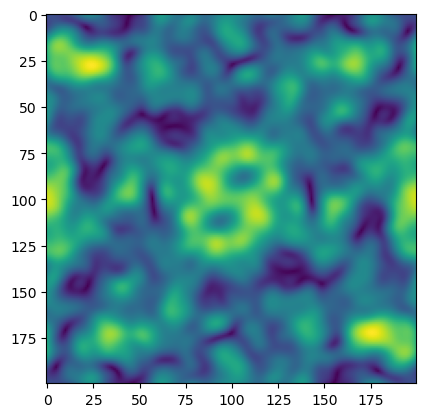

In [174]:
plt.imshow(np.abs(f['field'][0][0]))

In [178]:
f = h5py.File('/Users/joshlin/axion_cosmo/josh_notebooks/prod/100_final/earlyQCD_N2_runfinal_run2_0.hdf5')

BlockingIOError: [Errno 35] Unable to open file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

2108it [00:00, 5633.68it/s]
2364it [00:00, 3268.37it/s]
2738it [00:00, 6133.19it/s]
1474it [00:00, 2987.74it/s]
1296it [00:00, 6086.31it/s]
1576it [00:00, 6049.69it/s]
1542it [00:00, 6034.71it/s]
1482it [00:00, 2756.26it/s]
2204it [00:00, 6039.82it/s]


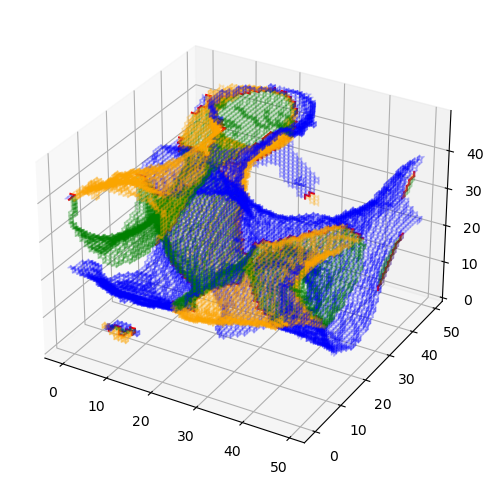

In [108]:
plotdomain(f['field'][40][0])

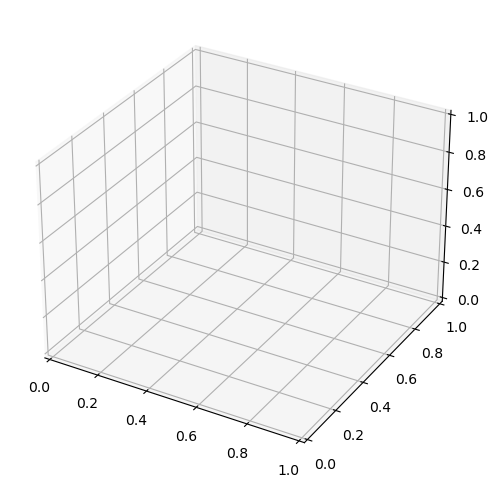

In [32]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection = '3d')

In [33]:
ax.add_collection3d??

In [23]:
f = h5py.File('/Users/joshlin/axion_cosmo/josh_notebooks/prod/100_final/earlyQCD_run3_7_0.hdf5')

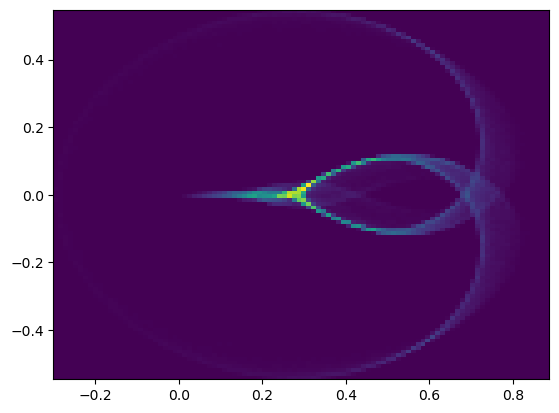

In [76]:
plt.hist2d(np.real(f['field'][100][0].flatten()),np.imag(f['field'][100][0].flatten()),bins=100)
plt.show()

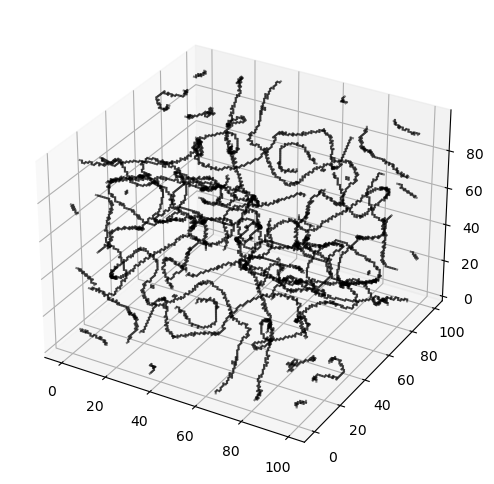

In [89]:
strings = stringid(f['field'][80][0][:,:,:])
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection = '3d')
for s in strings:
    ax.plot([s[0][0],s[1][0]],[s[0][1],s[1][1]],[s[0][2],s[1][2]],color='k',alpha=0.5)
plt.show()
plt.close()

11792it [00:03, 3677.21it/s]
12626it [00:02, 4655.48it/s]
14228it [00:02, 5184.43it/s]


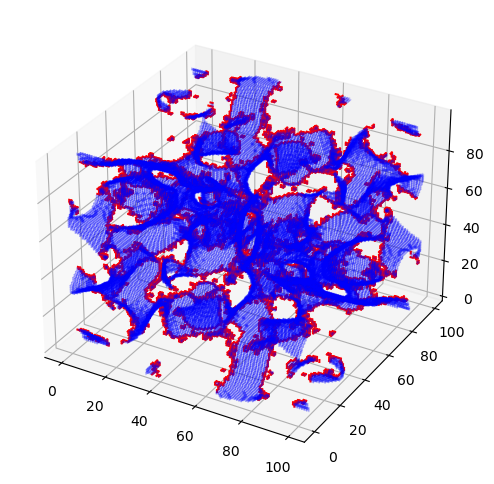

In [96]:
plotdomain(f['field'][60,0,:,:,:])

9178it [00:02, 4243.51it/s]
10132it [00:01, 5198.93it/s]
11314it [00:02, 4347.61it/s]


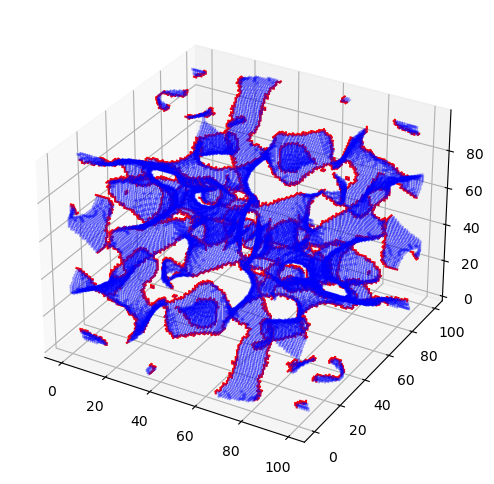

In [90]:
plotdomain(f['field'][80,0,:,:,:])

5048it [00:00, 5871.22it/s]
5590it [00:01, 3334.70it/s]
6126it [00:01, 4779.17it/s]


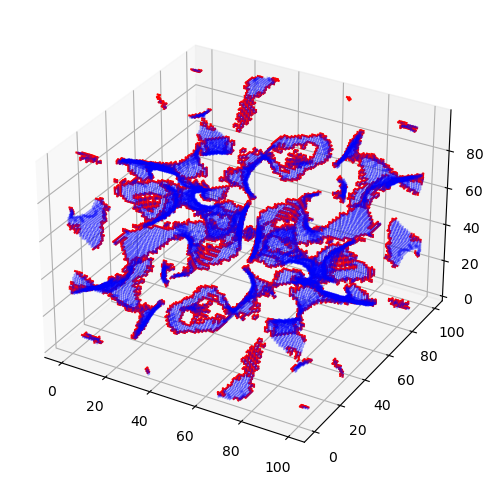

In [95]:
plotdomain(f['field'][102,0,:,:,:])